# Practice Numba cuda 5

This involves exploring CUDA-powered libraries/modules/packages.

__1)__  We looked at the sample code file `fft_demo.py` that demonstrates how to use some of the functionality provided by the the fast fourier transform module `numpy.fft` to accomplish common tasks like filtering and differentiation. Here we want to take the next step and employ the parallel fast fourier transform module provided by `cupy` which is billed as "A NumPy-compatible matrix library accelerated by CUDA". For more info about `cupy` you can check out the website:

https://cupy.chainer.org/

This problem focuses on using the `cupy.fft` module which aims to provide a "drop-in" parallel replacement for `numpy.fft` which means that they aim to provide GPU-accelerated versions of the same functionality with matching function calls (i.e., the same function names and arguments).

__1a)__ Install `cupy`. Their website gives full installation instructions, but this simple approach worked nicely for me, and I hope it does likewise for you:

- Open a terminal and run the "NVIDIA System Management Interface" command `nvidia-smi`.
- Note your CUDA version number which should appear in the upper right corner of the `nvidia-smi` output.
- Install `cupy` by running the appropriate terminal command for your CUDA version. If you are running CUDA 10.2, the installation command is `pip install cupy-cuda102`.
- Run one of the sample snippets from the `cupy` web page to make sure that things have installed properly.

__1b)__ Modify the `fft_demo.py` code (shown below) so that it runs in parallel on the GPU using by replacing the calls to functions from `numpy.fft` with calls to the corresponding functions from `cupy.fft`.

Note that `numpy` functions operate on `numpy` arrays and `cupy` functions operate on `cupy` arrays, so you will need to be able to get data across the "digital divide". For that purpose, check out the documentation for `cupy.asarray()` (to get `numpy` data into `cupy`) and `cupy.asnumpy()` (to get `cupy` data back to `numpy`).


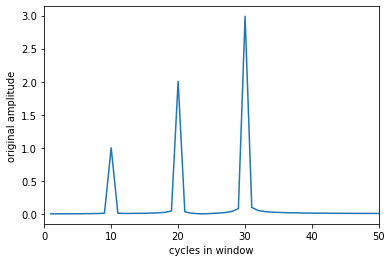

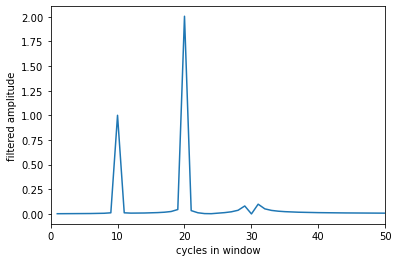

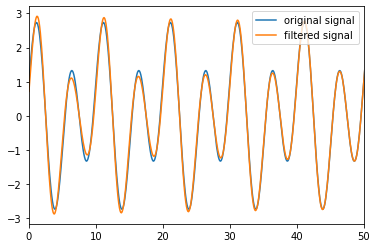

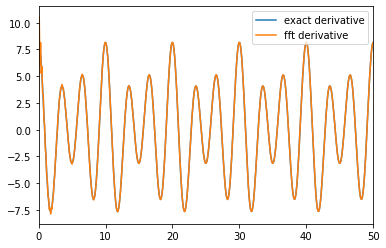

In [2]:
# fft_demo.py
# Sample code illustrating use of numpy.fft for filtering and differentiating

from  numba import cuda
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, ifft

pts = 1000
L = 100
w0 = 2.0 * np.pi/L
n1, n2, n3 = 10.0, 20.0, 30.0
a1, a2, a3 = 1., 2., 3.

#create signal data with 3 frequency components
x = np.linspace(0,L,pts)
y1 = a1*np.cos(n1*w0*x)
y2 = a2*np.sin(n2*w0*x)
y3 = a3*np.sin(n3*w0*x)
y = y1 + y2 + y3

#create signal including only 2 components
y12 = y1 + y2

#analytic derivative of signal
dy = w0*(-n1*a1*np.sin(n1*w0*x)
        +n2*a2*np.cos(n2*w0*x)
        +n3*a3*np.cos(n3*w0*x) )

#use fft.fftfreq to get frequency array corresponding to number of sample points
freqs = fftfreq(pts)
#compute number of cycles and radians in sample window for each frequency
nwaves = freqs*pts
nwaves_2pi = w0*nwaves

# compute the fft of the full signal
fft_vals = fft(y)

#mask the negative frequencies
mask = freqs>0
#double count at positive frequencies
fft_theo = 2.0 * np.abs(fft_vals/pts)
#plot fft of signal
plt.xlim((0,50))
plt.xlabel('cycles in window')
plt.ylabel('original amplitude')
plt.plot(nwaves[mask], fft_theo[mask])
plt.show()

#create a copy of the original fft to be used for filtering
fft_new = np.copy(fft_vals)
#filter out y3 by setting corr. frequency component(s) to zero
fft_new[np.abs(nwaves)==n3] = 0.
#plot fft of filtered signal
plt.xlim((0,50))
plt.xlabel('cycles in window')
plt.ylabel('filtered amplitude')
plt.plot(nwaves[mask], 2.0*np.abs(fft_new[mask]/pts))
plt.show()

#invert the filtered fft with numpy.fft.ifft
filt_data = np.real(ifft(fft_new))
#plot filtered data and compare with y12
plt.plot(x,y12, label='original signal')
plt.plot(x,filt_data, label='filtered signal')
plt.xlim((0,50))
plt.legend()
plt.show()

#multiply fft by 2*pi*sqrt(-1)*frequency to get fft of derivative
dy_fft = 1.0j*nwaves_2pi*fft_vals
#invert to reconstruct sampled values of derivative
dy_recon = np.real(ifft(dy_fft))
#plot reconstructed derivative and compare with analuytical version
plt.plot(x,dy,label='exact derivative')
plt.plot(x,dy_recon, label='fft derivative')
plt.xlim((0,50))
plt.legend()
plt.show()

__1c)__ Use `cupy` to do the following:

- Create `noise` consisting of an array of `pts` random values chosen from a uniform distribution over the interval $[-3,3]$.
- Create a noisy signal by adding noise to the original signal: `y_n = y + noise`
- Compute and plot the frequency content of the noisy signal.
- Create and apply an appropriate filter to suppress noise in the frequency domain.
- Invert the filtered fft to obtain a "denoised signal".
- Plot and compare the original, noisy, and denoised signals.

__2)__ We looked at the Jacobi iteration method for solving systems derived from finite difference approximations. The "big matrix" version of the 1D Poisson equation involves an $n \times n$ matrix $J(n)$ full of zeros except for the diagonals adjacent to the main diagonal where each of the entries is $1/2$. When we experimented with an iterative approach, we observed that the convergence was quite slow and that inspires a closer look at the eigenvalues and eigenvectors of the matrix $J(n)$.

Use `cupy` and `cupyx.scipy.spare.diags()` to construct the matrix $J(n)$ and compute its leading eigenvalue (the one with the largest magnitude) and the associated eigenvector for $n = 50$ and $n = 500$.  

Note that you may need to convert the sparse matrix to a dense array with `cupyx.scipy.sparse.dia_matrix.toarray()` before you can compute the eigenvalues/vectors.

What is the value of the leading eigenvalue and how does it behave as $n$ becomes large?

Provide a brief description of the corresponding eigenvector.

__ 3) __ Using `cupy`, explore the distribution of eigenvalues in random symmetric matrices. (Note that this concept has real applications in nuclear physics and quantum information theory. The seminal results are attributed to Eugene Wigner who won the Nobel Prize for Physics in 1963.)

__3a)__ Write python code using `cupy` to implement a function `rand_mat_gauss(n)` that creates a real symmetric $n \times n$ array of numbers selected from $N(0,1)$, the normal distribution with mean zero and standard deviation 1. Note that you can start by constructing a non-symmetric matrix $B$ and then construct the symmetric matrix $A = \frac{1}{\sqrt{2}}(B + B^T)$ whose entries should also belong to the distribution $N(0,1)$.

__3b)__ Test your code by creating a "small-ish" (say $10 \times 10$) array. Verify that the matrix is symmetric, and plot the histogram of the entries together with the normal distribution to verify that the distribution is plausible. For an example of how to do that with numpy, see
https://www.tutorialspoint.com/python_data_science/python_normal_distribution.htm

__3c)__ Create a matrix `m = rand_mat_gauss(n)` with $n = 1000$. Use `cupy` to compute the eigenvalues of the matrix, and plot the histrogram of the eigenvalues. (Recall that real symmetric matrices have real eigenvalues.) Describe the distribution of the eigenvalues.

__3d)__ Repeat 3c with $n = 2000$ and $n = 4000$. Describe the distribution of the eigenvalues. What features are independent of $n$? Identify a feature $F$ that depends on $n$ and determine the relationship; i.e. find $F(n)$. (You may find it enlightening to scale your eigenvalues by a factor of $\sqrt{n}$).

__ PROBLEM 4 IS OPTIONAL.__ Here we explore how the results obtained in problem 3 depend on the distribution from which the random matrix entries are chosen.

__4a)__ Repeat problem 3 but with matrix entries chosen uniformly from $\{-1,1\}$ instead of from a normal distribution. This time you will need to write a function `rand_mat_plusminus(n)` that produces an $n \times n$ array that is symmetric and any individual element is equally likely to be $+1$ or $-1$.

Again explore the distribution of the eigenvalues and the dependence on $n$. 

___For this problem, exclude the largest eigenvalue before computing the histogram.___


When the distribution from which elements are chosen is changed, what is preserved and what changes?

__4b)__ Repeat 4a but with matrix entries chosen randomly from a uniform distribution on the interval $[-1,1]$. This time you will need to write a function `rand_mat_uniform(n)` that produces an $n \times n$ array that is symmetric and any individual element is chosen randomly from $[-1,1]$.

Again explore the distribution of the eigenvalues and the dependence on $n$. When the distribution is changed this time, what is preserved and what changes?

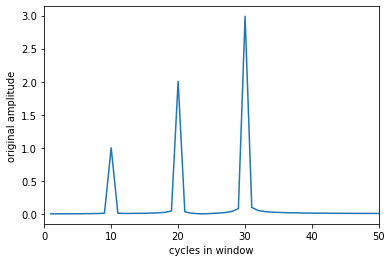

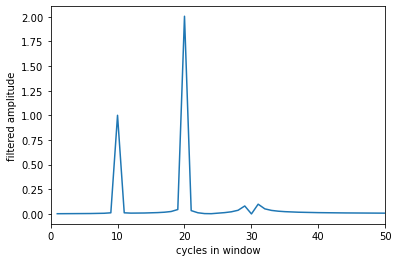

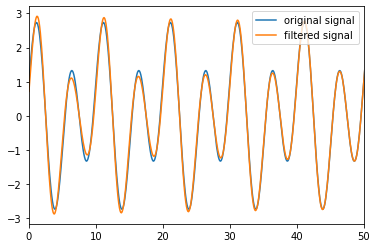

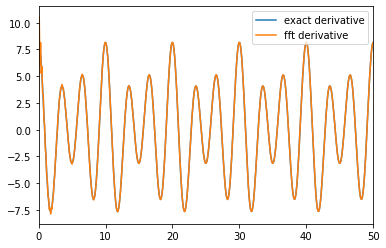

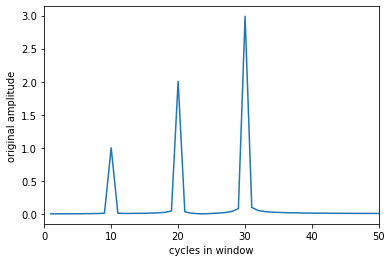

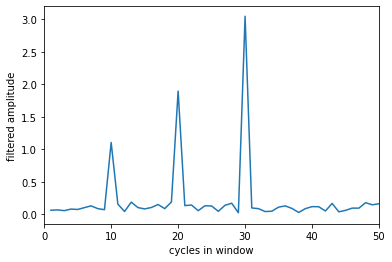

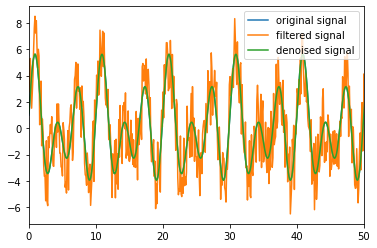

For n = 50, The eigenvalue of leading eigenvalue: 0.9981033287370439
For n = 50, The eigenvector that associate with the leading eigenvalue: 
[ 0.01219088 -0.02433551 -0.03638783  0.04830211  0.06003318 -0.07153651
 -0.08276848  0.09368648  0.1042491  -0.11441627 -0.12414941  0.13341162
  0.14216775 -0.15038458 -0.15803096  0.16507787  0.17149859 -0.17726875
 -0.18236647  0.18677241  0.19046986 -0.19344479 -0.19568592  0.19718475
  0.19793559 -0.19793559 -0.19718475  0.19568592  0.19344479 -0.19046986
 -0.18677241  0.18236647  0.17726875 -0.17149859 -0.16507787  0.15803096
  0.15038458 -0.14216775 -0.13341162  0.12414941  0.11441627 -0.1042491
 -0.09368648  0.08276848  0.07153651 -0.06003318 -0.04830211  0.03638783
 -0.02433551 -0.01219088]
For n = 500, The eigenvalue of leading eigenvalue: 0.9999803395762153
For n = 500, The eigenvector that associate with the leading eigenvalue: 
[-0.00039619  0.00079237  0.00118851 -0.00158461 -0.00198065  0.00237661
  0.00277247 -0.00316823 -0.0035

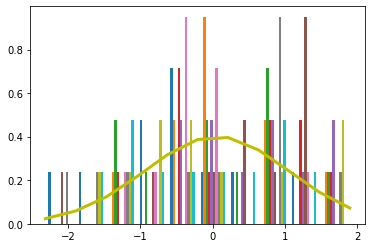

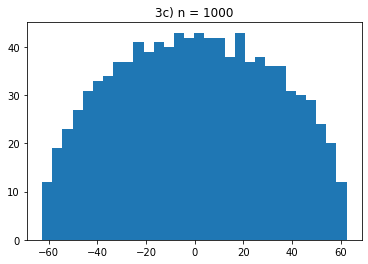

For n = 1000, mu = 0.0015959919782128132, sig = 0.9996437491193486
The normal distribution of the eigenvalues smoothly follows in histogram


For n = 1000, in rand_mat_gauss: 
eigval = 
[-6.26747512e+01 -6.19956099e+01 -6.11083868e+01 -6.08166642e+01
 -6.06448881e+01 -6.05816632e+01 -6.01004106e+01 -5.98315848e+01
 -5.92762827e+01 -5.92457125e+01 -5.90145035e+01 -5.86022547e+01
 -5.83077043e+01 -5.80338383e+01 -5.78536874e+01 -5.76163749e+01
 -5.74081952e+01 -5.70538491e+01 -5.68539141e+01 -5.65594032e+01
 -5.63592017e+01 -5.61484139e+01 -5.59890447e+01 -5.58057576e+01
 -5.56433818e+01 -5.53920177e+01 -5.49865232e+01 -5.48479655e+01
 -5.47754178e+01 -5.45756113e+01 -5.44028790e+01 -5.41263717e+01
 -5.37934956e+01 -5.36814684e+01 -5.33609508e+01 -5.33435669e+01
 -5.31065349e+01 -5.30248147e+01 -5.28339328e+01 -5.27912789e+01
 -5.24336342e+01 -5.23028324e+01 -5.21646366e+01 -5.18659326e+01
 -5.17883627e+01 -5.16750750e+01 -5.15553246e+01 -5.14450420e+01
 -5.12739164e+01 -5.09596874e+01 -

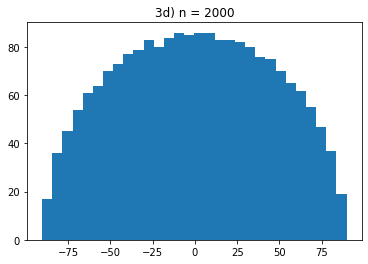

For n = 2000, mu = 6.054479515365813e-05, sig = 1.0004653033028286
The normal distribution of the eigenvalues smoothly follows in histogram
For n = 2000, in rand_mat_gauss: 
eigval = 
[-90.28489672 -88.9311568  -88.02947769 ...  88.27843038  89.16806372
  89.63823657]


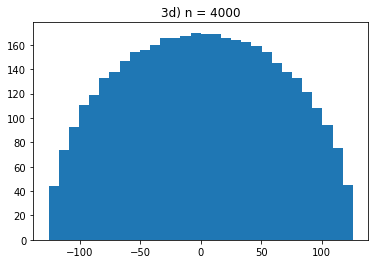

For n = 4000, mu = -7.57502866495304e-05, sig = 1.000117575523268
The normal distribution of the eigenvalues smoothly follows in histogram
For n = 4000, in rand_mat_gauss: 
eigval = 
[-126.14992731 -125.56681637 -125.25698968 ...  125.22794857  125.56077262
  125.96037903]
As shown in graph when n is increases, they are proportionally increases. 
The distribution of the eigenvalues are independent of n. 
Leading value of the eigvalues are proprotional to n


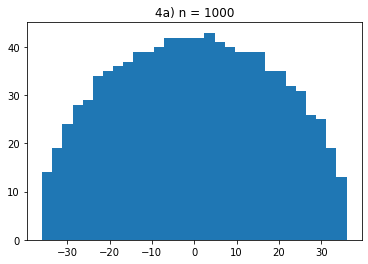

For n = 1000, mu = 0.000886, sig = 0.5775904388093703
For n = 1000, in rand_mat_gauss: 
eigval = 
[-3.59327475e+01 -3.56619667e+01 -3.56224855e+01 -3.54129319e+01
 -3.51207690e+01 -3.50977395e+01 -3.47688750e+01 -3.45931099e+01
 -3.45108898e+01 -3.41136688e+01 -3.39862680e+01 -3.39100107e+01
 -3.37251103e+01 -3.36584433e+01 -3.35066215e+01 -3.32520145e+01
 -3.31539986e+01 -3.30326530e+01 -3.29591241e+01 -3.28187196e+01
 -3.27607778e+01 -3.26577105e+01 -3.25277718e+01 -3.23982618e+01
 -3.22778278e+01 -3.22281724e+01 -3.19950160e+01 -3.18901671e+01
 -3.18144584e+01 -3.16011526e+01 -3.15612630e+01 -3.13734592e+01
 -3.12018442e+01 -3.10750423e+01 -3.09963377e+01 -3.08766536e+01
 -3.08166548e+01 -3.06038687e+01 -3.05526412e+01 -3.04213886e+01
 -3.03563162e+01 -3.01701970e+01 -3.01492098e+01 -3.00254962e+01
 -2.98585557e+01 -2.98527248e+01 -2.97355545e+01 -2.96706372e+01
 -2.95271840e+01 -2.93586985e+01 -2.93347934e+01 -2.93026496e+01
 -2.92028974e+01 -2.90572374e+01 -2.90081576e+01 -2.89894

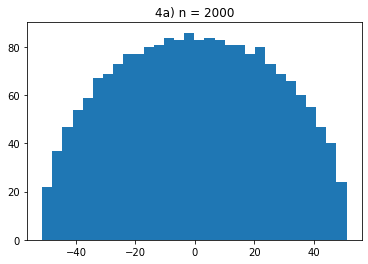

For n = 2000, mu = 0.000119, sig = 0.5773795206266042
For n = 2000, in rand_mat_gauss: 
eigval = 
[-51.42940465 -51.30808317 -51.13800651 ...  50.57058426  50.89465255
  51.07440599]


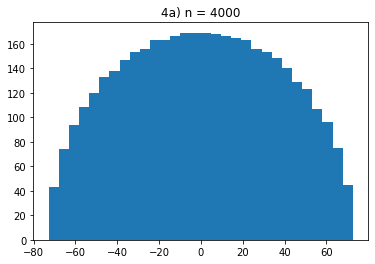

For n = 4000, mu = -2.75625e-05, sig = 0.5776709967536411
For n = 4000, in rand_mat_gauss: 
eigval = 
[-72.88933237 -72.63197558 -72.29636771 ...  72.15173848  72.21968637
  72.67801591]
As shown in histgram, when n increases, histogram also increases.
 As n is increases the the distribution doesnt changing much.


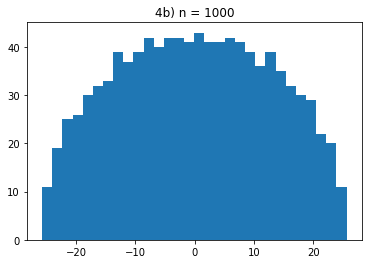

For n = 1000, mu = 0.0007913731549896122, sig = 0.4086895702138853
For n = 1000, in rand_mat_gauss: 
eigval = 
[-2.57224639e+01 -2.55022663e+01 -2.53924063e+01 -2.50856555e+01
 -2.49099451e+01 -2.46928248e+01 -2.46094648e+01 -2.45362268e+01
 -2.44341747e+01 -2.42295399e+01 -2.41710806e+01 -2.38679213e+01
 -2.37868001e+01 -2.37017622e+01 -2.35623306e+01 -2.35032528e+01
 -2.33020720e+01 -2.32905263e+01 -2.31594225e+01 -2.31256314e+01
 -2.30339949e+01 -2.29555143e+01 -2.28599277e+01 -2.28345153e+01
 -2.27826641e+01 -2.27413430e+01 -2.26210369e+01 -2.25216171e+01
 -2.25052092e+01 -2.23552579e+01 -2.22546189e+01 -2.22521643e+01
 -2.22074639e+01 -2.21191678e+01 -2.20178591e+01 -2.19706107e+01
 -2.18724290e+01 -2.17764070e+01 -2.16280565e+01 -2.16209995e+01
 -2.15574958e+01 -2.14563812e+01 -2.14057776e+01 -2.13235105e+01
 -2.12655170e+01 -2.11818394e+01 -2.11337574e+01 -2.11265569e+01
 -2.09610801e+01 -2.09383406e+01 -2.09076664e+01 -2.07636560e+01
 -2.07086960e+01 -2.06709229e+01 -2.06166205

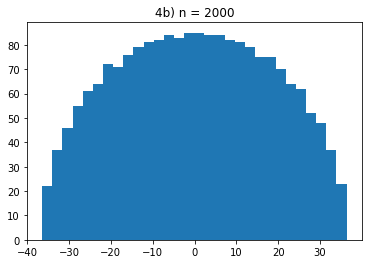

For n = 2000, mu = -5.1577310725284605e-05, sig = 0.40833271242584984
For n = 2000, in rand_mat_gauss: 
eigval = 
[-36.43873963 -36.22978807 -35.945173   ...  35.89878255  36.16226579
  36.32186783]


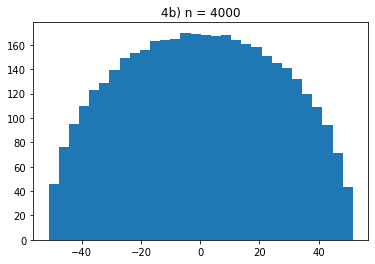

For n = 4000, mu = -0.00024075257023733985, sig = 0.4083160074618671
For n = 4000, in rand_mat_gauss: 
eigval = 
[-51.26161285 -51.17147906 -51.07953619 ...  51.15341206  51.49380727
  51.57973227]
As shown in the graph we can see now that it does not change as n increases. It shows that distribution are most likely set


In [1]:
import numpy as np
##Import other packages here##
import cupy as cp
import matplotlib.pyplot as plt
from cupy.fft import fftfreq, fft, ifft
import math
from cupyx import scipy

# cupy source
# https://docs-cupy.chainer.org/_/downloads/en/v7.0.0/pdf/



# 1a) install cupy
# fft.fftfreq to get frequency array corresponding to number of sample points
# cupy.fft.fftfreq #Return the FFT sample frequencies.

# compute the fft of the full signal
# cupy.fft.fft #Compute the one-dimensional FFT.

# invert the filtered fft with numpy.fft.ifft
# cupy.fft.ifft #Compute the one-dimensional inverse FFT.

# move the array to the host.
# plot -> plt.plot(cp.asnumpy(x), cp.asnumpy(y))

def cupy_fft():
    
    """
    Modify the code below so it calls the cupy fft function
    """

    pts = 1000
    L = 100
    w0 = 2.0 * cp.pi/L
    n1, n2, n3 = 10.0, 20.0, 30.0
    a1, a2, a3 = 1., 2., 3.

    #create signal data with 3 frequency components
    x = cp.linspace(0,L,pts)
    y1 = a1*cp.cos(n1*w0*x)
    y2 = a2*cp.sin(n2*w0*x)
    y3 = a3*cp.sin(n3*w0*x)
    y = y1 + y2 + y3

    #create signal including only 2 components
    y12 = y1 + y2

    #analytic derivative of signal
    dy = w0*(-n1*a1*cp.sin(n1*w0*x)
            +n2*a2*cp.cos(n2*w0*x)
            +n3*a3*cp.cos(n3*w0*x) )

    #use fft.fftfreq to get frequency array corresponding to number of sample points
    freqs = fftfreq(pts)
    #compute number of cycles and radians in sample window for each frequency
    nwaves = freqs*pts
    nwaves_2pi = w0*nwaves

    # compute the fft of the full signal
    fft_vals = fft(y)

    #mask the negative frequencies
    mask = freqs>0
    #double count at positive frequencies
    fft_theo = 2.0 * cp.abs(fft_vals/pts)
    #plot fft of signal
    plt.xlim((0,50))
    plt.xlabel('cycles in window')
    plt.ylabel('original amplitude')
    plt.plot(cp.asnumpy(nwaves[mask]), cp.asnumpy(fft_theo[mask]))
    plt.show()

    #create a copy of the original fft to be used for filtering
    fft_new = cp.copy(fft_vals)
    #filter out y3 by setting corr. frequency component(s) to zero
    fft_new[cp.abs(nwaves)==n3] = 0.
    #plot fft of filtered signal
    plt.xlim((0,50))
    plt.xlabel('cycles in window')
    plt.ylabel('filtered amplitude')
    plt.plot(cp.asnumpy(nwaves[mask]), cp.asnumpy(2.0*cp.abs(fft_new[mask]/pts)))
    plt.show()

    #invert the filtered fft with numpy.fft.ifft
    filt_data = cp.real(ifft(fft_new))
    #plot filtered data and compare with y12
    plt.plot(cp.asnumpy(x), cp.asnumpy(y12), label='original signal')
    plt.plot(cp.asnumpy(x), cp.asnumpy(filt_data), label='filtered signal')
    plt.xlim((0,50))
    plt.legend()
    plt.show()

    #multiply fft by 2*pi*sqrt(-1)*frequency to get fft of derivative
    dy_fft = 1.0j*nwaves_2pi*fft_vals
    #invert to reconstruct sampled values of derivative
    dy_recon = cp.real(ifft(dy_fft))
    #plot reconstructed derivative and compare with analuytical version
    plt.plot(cp.asnumpy(x), cp.asnumpy(dy), label='exact derivative')
    plt.plot(cp.asnumpy(x), cp.asnumpy(dy_recon), label='fft derivative')
    plt.xlim((0,50))
    plt.legend()
    plt.show()

def cupy_filter():
    
    """
    Implement code below to:
    Create noise consisting of an array of pts random values chosen from a uniform distribution over the interval [−3,3]
    Create a noisy signal by adding noise to the original signal: y_n = y + noise
    Compute and plot the frequency content of the noisy signal.
    Create and apply an appropriate filter to suppress noise in the frequency domain.
    Invert the filtered fft to obtain a "denoised signal".
    Plot and compare the original, noisy, and denoised signals.
    """

    # pass
    pts = 1000
    L = 100
    w0 = 2.0 * cp.pi/L
    n1, n2, n3 = 10.0, 20.0, 30.0
    a1, a2, a3 = 1., 2., 3.

    #create signal data with 3 frequency components
    x = cp.linspace(0,L,pts)
    y1 = a1*cp.cos(n1*w0*x)
    y2 = a2*cp.sin(n2*w0*x)
    y3 = a3*cp.sin(n3*w0*x)
    y = y1 + y2 + y3

    #noisy signal: uniform distribution range[-3 3]
    ns = cp.random.uniform(-3, 3, pts)

    # y_n = y + noise
    y_n = y + ns

    # #create signal including only 2 components
    # y12 = y1 + y2

    # #analytic derivative of signal
    # dy = w0*(-n1*a1*cp.sin(n1*w0*x)
    #         +n2*a2*cp.cos(n2*w0*x)
    #         +n3*a3*cp.cos(n3*w0*x) )

    #use fft.fftfreq to get frequency array corresponding to number of sample points
    freqs = fftfreq(pts)
    #compute number of cycles and radians in sample window for each frequency
    nwaves = freqs*pts
    # nwaves_2pi = w0*nwaves

    # compute the fft of the full signal
    fft_vals = fft(y)

    # with noisy signal:
    fft_vals_ns = fft(y_n)


    #mask the negative frequencies
    mask = freqs>0
    
    #double count at positive frequencies
    fft_theo = 2.0 * cp.abs(fft_vals/pts)
    
    # with noisy signal:
    fft_theo_ns = 2.0 * cp.abs(fft_vals_ns/pts)


# plot
    #plot fft of signal
    plt.xlim((0,50))
    plt.xlabel('cycles in window')
    plt.ylabel('original amplitude')
    plt.plot(cp.asnumpy(nwaves[mask]), cp.asnumpy(fft_theo[mask]))
    plt.show()




    #create a copy of the original fft to be used for filtering
    fft_new = cp.copy(fft_vals)
    #filter out y3 by setting corr. amplitude component(s) to zero  ##helping source # checked about single side spectrum
    fft_new[cp.abs(fft_new)<=a1/2] = 0. 
    #plot fft of filtered signal

# plot fft noisy signal
    plt.xlim((0,50))
    plt.xlabel('cycles in window')
    plt.ylabel('filtered amplitude')
    # plt.plot(cp.asnumpy(nwaves[mask]), cp.asnumpy(2.0*cp.abs(fft_new[mask]/pts)))
    plt.plot(cp.asnumpy(nwaves[mask]),cp.asnumpy(fft_theo_ns[mask]))
    plt.show()



    #invert the filtered fft with numpy.fft.ifft
    filt_data = cp.real(ifft(fft_new))


    #plot filtered data and compare origin, noisy signal, denoised signal
    plt.plot(cp.asnumpy(x), cp.asnumpy(y), label='original signal')
    plt.plot(cp.asnumpy(x), cp.asnumpy(y_n), label='filtered signal')
    plt.plot(cp.asnumpy(x), cp.asnumpy(filt_data), label='denoised signal')
    plt.xlim((0,50))
    plt.legend()
    plt.show()

    # #multiply fft by 2*pi*sqrt(-1)*frequency to get fft of derivative
    # dy_fft = 1.0j*nwaves_2pi*fft_vals
    # #invert to reconstruct sampled values of derivative
    # dy_recon = cp.real(ifft(dy_fft))
    # #plot reconstructed derivative and compare with analuytical version
    # plt.plot(cp.asnumpy(x), cp.asnumpy(dy), label='exact derivative')
    # plt.plot(cp.asnumpy(x), cp.asnumpy(dy_recon), label='fft derivative')
    # plt.xlim((0,50))
    # plt.legend()
    # plt.show()

def cupy_eig(mat):
    """
    Returns the eigen values of square matrix mat
    """
    # https://docs-cupy.chainer.org/en/stable/reference/generated/cupy.linalg.eigh.html
    w, v = cp.linalg.eigh(mat)
    # w eigenvalues
    # v eigenvectors
    return w, v

def cupy_J(n):
    """
    Constructs the nxn matrix J (as described in q2)
    Returns J, leading eigenvalue of J, and the associated eigenvector
    """
    # main diagonal where each of the entries is 1/2
    # Use cupyx.scipy.spare.diags()
    # http://wwwens.aero.jussieu.fr/lefrere/master/SPE/docs-python/scipy-doc/generated/scipy.sparse.diags.html
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html
    # 𝑛×𝑛 matrix 𝐽(𝑛) full of zeros except for the diagonals adjacent to the main diagonal where each of the entries is  1/2
    J = scipy.sparse.diags([1/2, 1/2], [1,-1], shape=(n,n)).toarray()
    w, v = cupy_eig(J)

    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))

    return J, abs(w[idx]), v[idx]

def rand_mat_gauss(n):
    """
    Returns nxn size array of random numbers sampled from a normal distribution with a mean of 0 and standard deviation of 1
    (Uses cupy to generate the random matrix)
    """
    # 3a)
    #B 𝑁(0,1) , the normal distribution with mean zero and standard deviation 1.
    # cupy.random.normal #Returns an array of normally distributed samples.
    B = cp.random.normal(0, 1, (n,n))
    A = (1/cp.sqrt(2)) * (B + cp.transpose(B))
    return A

def rand_mat_plusminus(n):
    """
    Returns nxn size array of random numbers uniformly distributed on the 2-value set {-1,1}
    OPTIONAL
    """
    # p4a)
    # repeat problem 3 but with matrix entries chosen uniformly from  {−1,1}  
    # instead of from a normal distribution
    # cupy.random.rand #Returns an array of uniform random values over the in- terval[0, 1).
    # cupy.random.randint #Returns a scalar or an array of integer values over [low, high).
    # cupy.random.random_integers #Returnascalaroranarrayofintegervaluesover[low, high]

    B = cp.random.random_integers(-1, 1, (n,n))
    A = (1/2) * (B + cp.transpose(B))
    return A

def rand_mat_uniform(n):
    """
    Returns nxn size array of random numbers uniformly distrubted on the range [-1,1]
    OPTIONAL
    """
    # p4b)
    # Repeat 4a but with matrix entries chosen randomly from a uniform distribution on the interval  [−1,1]
    # produces an  𝑛×𝑛  array that is symmetric and any individual element is chosen randomly from  [−1,1] .
    B = cp.random.uniform(-1, 1, (n,n))
    A = (1/2) * (B + cp.transpose(B))
    return A   

# https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


if __name__ == "__main__":

    #Fill in code here to call functions
    # pass

# Problem1)
    # 1b)
    cupy_fft()

    # 1c)
    cupy_filter()



# 
# 
# 

# Problem2)
    # 2) For n = 50
    n = 50
    J, w, v = cupy_J(n)
    print('For n = {0}, The eigenvalue of leading eigenvalue: {1}'.format(n, w))
    print('For n = {0}, The eigenvector that associate with the leading eigenvalue: \n{1}'.format(n, v))
    # For n = 500
    n = 500
    J, w, v = cupy_J(n)
    print('For n = {0}, The eigenvalue of leading eigenvalue: {1}'.format(n, w))
    print('For n = {0}, The eigenvector that associate with the leading eigenvalue: \n{1}'.format(n, v))

    # What is the value of the leading eigenvalue and how does it behave as  𝑛  becomes large?
    print('As n increases, the leading eigenvalue also increases')
    print('The magnitude of eigenvector matrix are shows symmetric')




# 
# 
# 

# problem 3)
    # 3b)
    # 10x10 array
    # Verify symmetric matrix
    # plot histogram N
    n = 10
    
    Anxn = rand_mat_gauss(n)
    # verify symmetric matrix
    check = check_symmetric(Anxn)
    print('This is {} that the matrix is symmetric'.format(check))    



    # plot histogram N
    mu, sig = cp.mean(Anxn), cp.std(Anxn)
    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))


# # https://www.tutorialspoint.com/python_data_science/python_normal_distribution.htm

    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)
    s = cp.squeeze(Anxn)
    s = cp.asnumpy(s)

    plt.figure()
    count, bins, ignored = plt.hist(s, density=True)
    plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) *
             np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.show()




    # 3c)
    # Create a matrix m = rand_mat_gauss(n) with  𝑛=1000 
    n = 1000
    m = rand_mat_gauss(n)

    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))


    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('3c) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('The normal distribution of the eigenvalues smoothly follows in histogram\n\n')
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))



    # 3d) 
    # repeat 3c with  𝑛=2000  and  𝑛=4000
    # For n = 2000
    n = 2000 #200
    m = rand_mat_gauss(n)

    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))


    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('3d) n = ' + str(n))    
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('The normal distribution of the eigenvalues smoothly follows in histogram')
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))


    # For n = 4000
    n = 4000
    m = rand_mat_gauss(n)

    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))


    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('3d) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('The normal distribution of the eigenvalues smoothly follows in histogram')
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    

# What features are independent of  𝑛 ?
    print('As shown in graph when n is increases, they are proportionally increases. \nThe distribution of the eigenvalues are independent of n. \nLeading value of the eigvalues are proprotional to n')



# 
# 
# 

# problem4)
    # p4a)
    # epeat problem 3 but with matrix entries chosen uniformly from  {−1,1}  
    # instead of from a normal distribution
    # a)
    # For n = 1000, 2000, 4000
# For n = 1000
    n = 1000
    m = rand_mat_plusminus(n)
    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))
    # For this problem, exclude the largest eigenvalue before computing the histogram.
    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))
    w = np.delete(cp.asnumpy(w), cp.asnumpy(idx))

    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('4a) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    


# For n = 2000
    n = 2000
    m = rand_mat_plusminus(n)
    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))
    # For this problem, exclude the largest eigenvalue before computing the histogram.
    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))
    w = np.delete(cp.asnumpy(w), cp.asnumpy(idx))
    

    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('4a) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    


# For n = 4000
    n = 4000
    m = rand_mat_plusminus(n)
    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))
    # For this problem, exclude the largest eigenvalue before computing the histogram.
    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))
    w = np.delete(cp.asnumpy(w), cp.asnumpy(idx))
    

    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('4a) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    

# When the distribution from which elements are chosen is changed, what is preserved and what changes?
    print('As shown in histgram, when n increases, histogram also increases.\n As n is increases the the distribution doesnt changing much.')


# 
# 
# 
    # p4b)
    # b)
# Again explore the distribution of the eigenvalues and the dependence on  𝑛 . When the distribution is changed this time, what is preserved and what changes?
    # For n = 1000, 2000, 4000
# For n = 1000
    n = 1000
    m = rand_mat_uniform(n)
    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))
    # For this problem, exclude the largest eigenvalue before computing the histogram.
    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))
    w = np.delete(cp.asnumpy(w), cp.asnumpy(idx))

    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('4b) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    


# For n = 2000
    n = 2000
    m = rand_mat_uniform(n)
    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))
    # For this problem, exclude the largest eigenvalue before computing the histogram.
    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))
    w = np.delete(cp.asnumpy(w), cp.asnumpy(idx))
    

    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('4b) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    


# For n = 4000
    n = 4000
    m = rand_mat_uniform(n)
    # cupy to compute the eigenvalues of the matrix
    w, v = cupy_eig(m)
    # print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))
    # For this problem, exclude the largest eigenvalue before computing the histogram.
    # max leading eigval (one with large magnitude)
    idx = cp.argmax(abs(w))
    w = np.delete(cp.asnumpy(w), cp.asnumpy(idx))
    

    # plot the histrogram of the eigenvalues
    mu, sig = cp.mean(m), cp.std(m)
    mu = cp.asnumpy(mu)
    sigma = cp.asnumpy(sig)

    plt.figure()
    count, bins, ignored = plt.hist(cp.asnumpy(w), bins = 30)
    # plt.plot(bins, 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2)), linewidth=3, color='y')
    plt.title('4b) n = ' + str(n))
    plt.show()

    print('For n = {0}, mu = {1}, sig = {2}'.format(n, mu, sig))
    print('For n = {0}, in rand_mat_gauss: \neigval = \n{1}'.format(n, w))    

# Again explore the distribution of the eigenvalues and the dependence on  𝑛 . When the distribution is changed this time, what is preserved and what changes?
    print('As shown in the graph we can see now that it does not change as n increases. It shows that distribution are most likely set')
